In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.stats import gaussian_kde


In [ ]:
df = pd.read_excel('CPI_monthly_2025.xlsx', skiprows=11)
print(df.shape)
df.head()

c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(1344, 4)


,Series ID,Year,Period,Value
0,CUUR0000SA0,1913,M02,0.0
1,CUUR0000SA0,1913,M03,0.0
2,CUUR0000SA0,1913,M04,0.0
3,CUUR0000SA0,1913,M05,-1.0
4,CUUR0000SA0,1913,M06,1.0


In [21]:
df.columns

Index(['Series ID', 'Year', 'Period', 'Value'], dtype='object')

In [22]:
df = df.drop(columns=['Series ID'])
print(df.shape)
df.head()

(1427, 3)


,Year,Period,Value
0,1913,M01,9.8
1,1913,M02,9.8
2,1913,M03,9.8
3,1913,M04,9.8
4,1913,M05,9.7


In [23]:
df = df[df['Period'].str.startswith('M')]


In [24]:
# Create the "Date" column:
# - Year is taken directly from the 'Year' column
# - Month is extracted from the 'Period' column (e.g., 'M01' → '01')
# - Day is fixed as '01'
df['Date'] = df['Year'].astype(str) + '-' + df['Period'].str[1:] + '-01'
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Year,Period,Value,Date
0,1913,M01,9.8,1913-01-01
1,1913,M02,9.8,1913-02-01
2,1913,M03,9.8,1913-03-01
3,1913,M04,9.8,1913-04-01
4,1913,M05,9.7,1913-05-01


In [25]:
df = df[['Date', 'Value']]  # Reorder columns
df.columns = ['timestamp', 'CPI']  # Rename columns for consistency
df.head()

,timestamp,CPI
0,1913-01-01,9.8
1,1913-02-01,9.8
2,1913-03-01,9.8
3,1913-04-01,9.8
4,1913-05-01,9.7


In [26]:
df = df.set_index('timestamp')
df.head()

,CPI
timestamp,
1913-01-01,9.8
1913-02-01,9.8
1913-03-01,9.8
1913-04-01,9.8
1913-05-01,9.7


## Exploratory Data Analysis

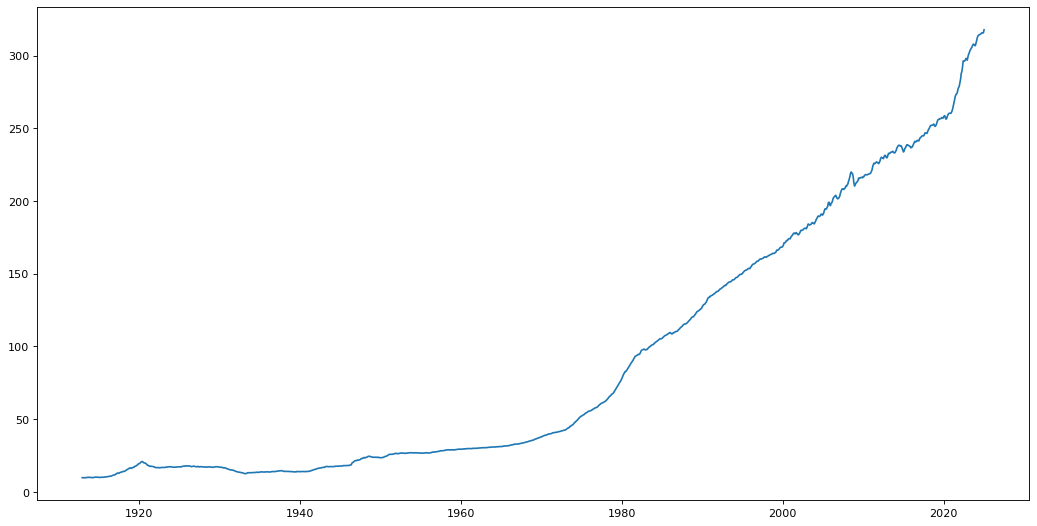

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)
plt.plot(df.index,df.CPI)

## CHECK OUTLIER

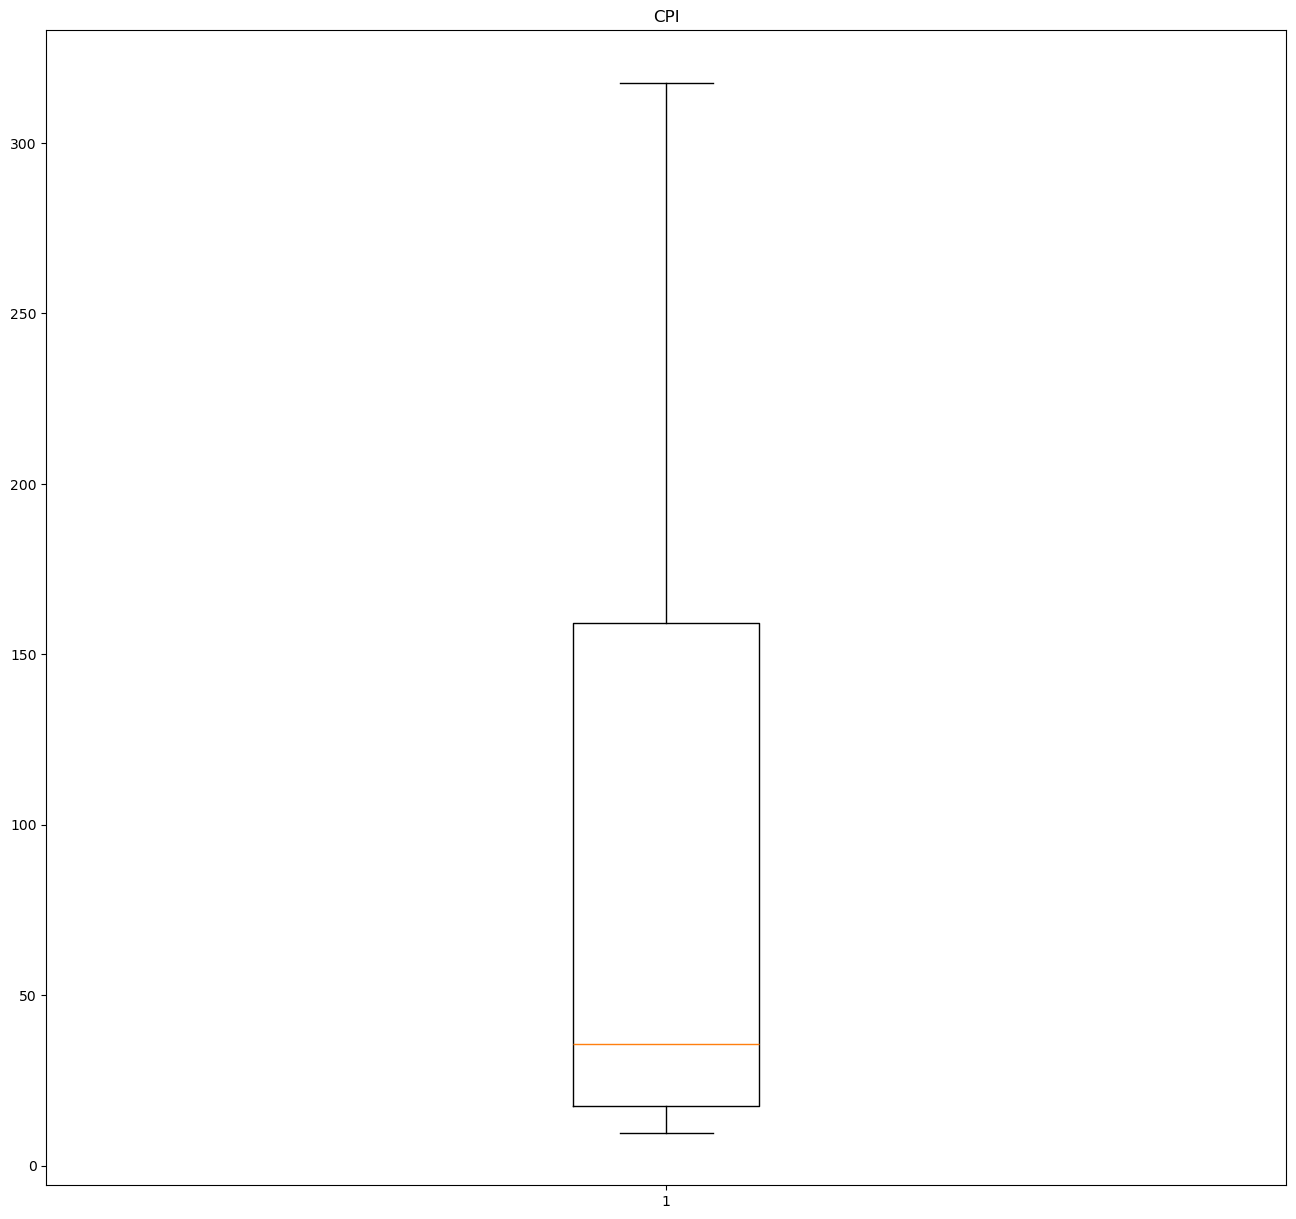

In [28]:
def box_plot(df,i):
  plt.boxplot(df.iloc[:,i])
  plt.title(df.columns.values.tolist()[i])
  plt.show()
box_plot(df,0)

In [29]:

# q1 = np.percentile(df['CPI'],25)
# q3 = np.percentile(df['CPI'],75)
# boolean_condition = (df['CPI'] < q1 - (q3-q1)*1.3) | (df['CPI'] > q3 + (q3-q1)*1.3)
# column_name = 'CPI'
# new_value = np.mean(df['CPI'])

# df.loc[boolean_condition, column_name] = new_value
# df.head()

In [30]:

# box_plot(df,0)

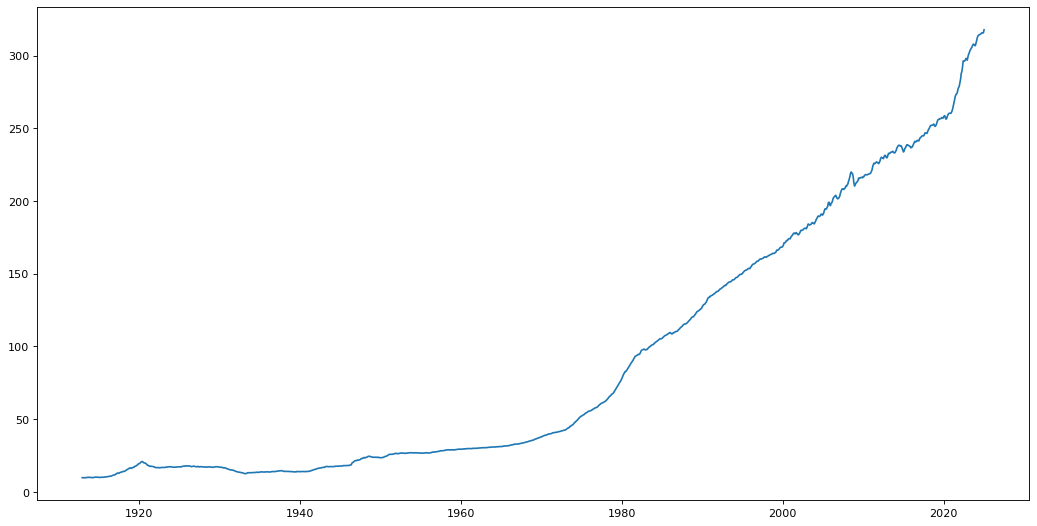

In [31]:
figure(figsize=(16, 8), dpi=80)
plt.plot(df.index,df.CPI)

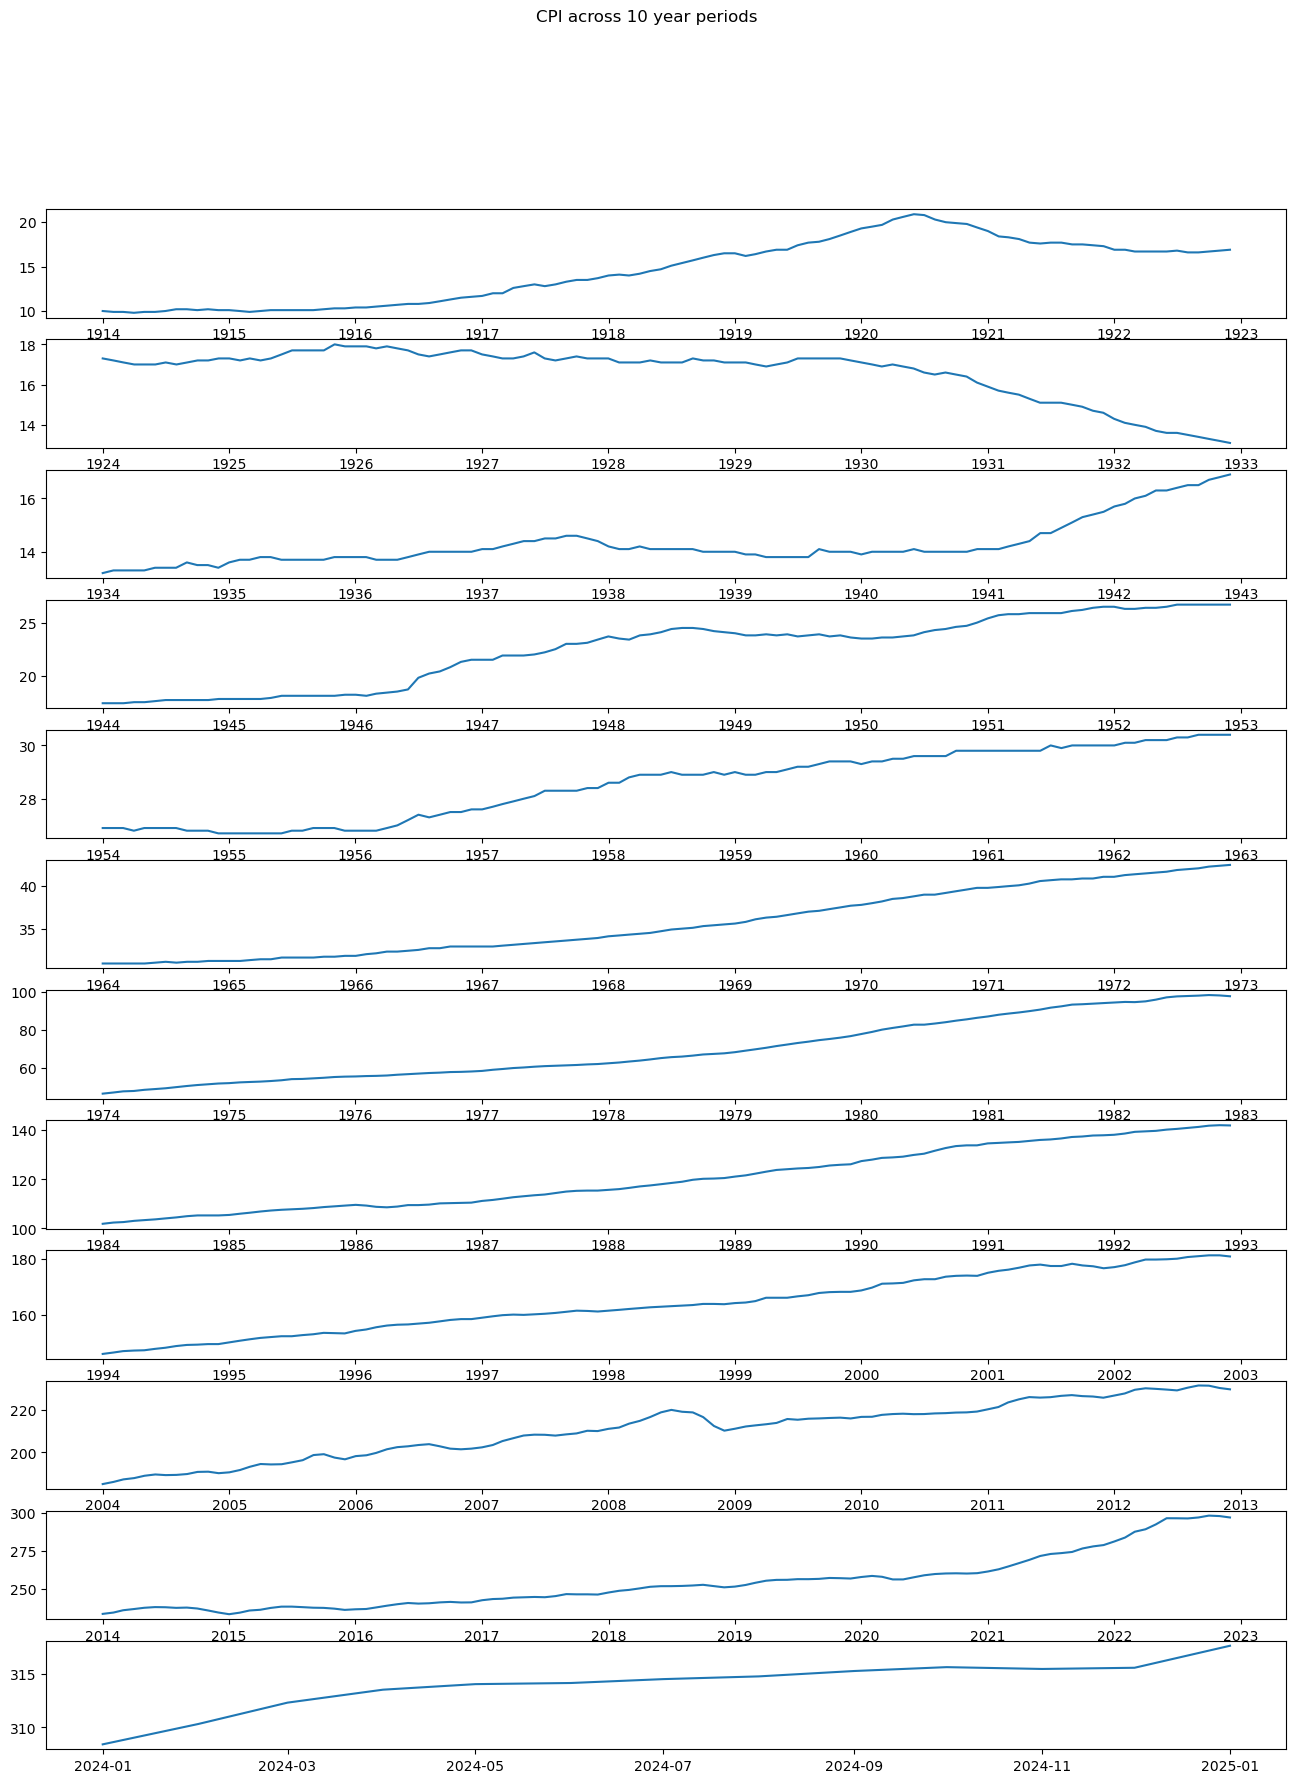

In [35]:

from pandas.tseries.offsets import YearEnd
plt.rc("figure",figsize=(16,20))
year = df.index.year.min()

fig, axs = plt.subplots((df.index.year.max() - df.index.year.min())//10 + 1)
fig.suptitle('CPI across 10 year periods')
count = 0

while year in df.index.year:
  df_temp = df[(df.index.year > year) & (df.index.year < year+10)]
  axs[count].plot(df_temp.index,df_temp.CPI)
  year = year + 10
  count = count + 1

## DECOMPOSITION

In [38]:
# !pip install statsmodels

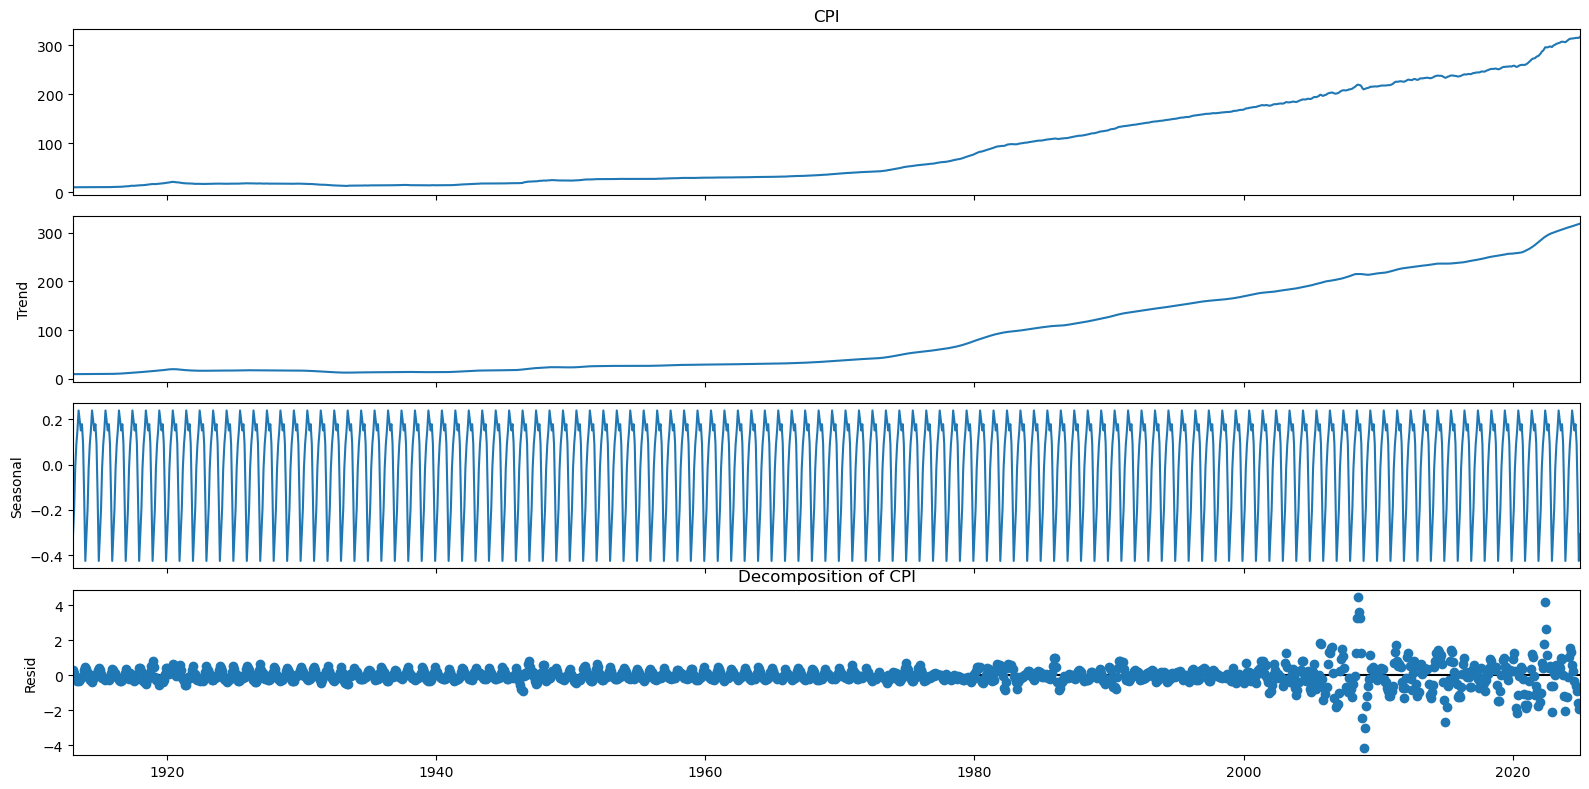

In [39]:

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc("figure",figsize=(16,8))

def decompose(df, i):
  series = df.iloc[:,i]
  result = seasonal_decompose(series, model='additive',extrapolate_trend='freq',period=12)
  result.plot()
  plt.title('Decomposition of '+ df.columns.values.tolist()[i])
  plt.show()
  return result
result = decompose(df, 0)

## Stationarity

In [42]:

from statsmodels.tsa.stattools import adfuller

def ADF_Test(df,df_adf,i):	
	series = df.iloc[:,i]
	X = series.values
	result = adfuller(X)
	df_adf_i = pd.DataFrame({'Output':df.columns.values.tolist()[i],'ADF Statistic':result[0],'p-value':result[1],'CriticalValues':result[4]})
	df_adf = df_adf._append(df_adf_i,ignore_index = True)
	return df_adf

In [43]:

df_adf = pd.DataFrame()
df_adf = ADF_Test(df,df_adf,0)
df_adf
     

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,4.240883,1.0,-3.435291
1,CPI,4.240883,1.0,-2.863722
2,CPI,4.240883,1.0,-2.567932


## Removing seasonality to make data stationary

In [45]:
df_nonseasonal = pd.DataFrame()

# Option 1: Use fillna
df_nonseasonal['CPI'] = df['CPI'] - df.shift(12)['CPI'].fillna(0)

# Option 2: Use replace with np.nan
# df_nonseasonal['CPI'] = df['CPI'] - df.shift(12).replace(np.nan, 0)['CPI']

df_nonseasonal.head()
     

,CPI
timestamp,
1913-01-01,9.8
1913-02-01,9.8
1913-03-01,9.8
1913-04-01,9.8
1913-05-01,9.7


In [46]:

df_adf = pd.DataFrame()
df_adf = ADF_Test(df_nonseasonal,df_adf,0)
df_adf

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-2.592552,0.094546,-3.435310
1,CPI,-2.592552,0.094546,-2.863730
2,CPI,-2.592552,0.094546,-2.567936


## Subtracting Lags to make data stationary

In [49]:
# Option 1: Replace np.nan
df_nonseasonal['lag1'] = df_nonseasonal['CPI'] - df_nonseasonal.shift(1).replace(np.nan, 0)['CPI']

# Option 2: Using fillna to replace NaN values with 0
df_nonseasonal['lag1'] = df_nonseasonal['CPI'] - df_nonseasonal.shift(1)['CPI'].fillna(0)

df_nonseasonal.head()

,CPI,lag1
timestamp,,
1913-01-01,9.8,9.8
1913-02-01,9.8,0.0
1913-03-01,9.8,0.0
1913-04-01,9.8,0.0
1913-05-01,9.7,-0.1


In [50]:
df_adf = pd.DataFrame()
df_adf = ADF_Test(pd.DataFrame(df_nonseasonal['lag1']),df_adf,0)
df_adf
     

,Output,ADF Statistic,p-value,CriticalValues
0,lag1,-13.088697,1.807245e-24,-3.435310
1,lag1,-13.088697,1.807245e-24,-2.863730
2,lag1,-13.088697,1.807245e-24,-2.567936


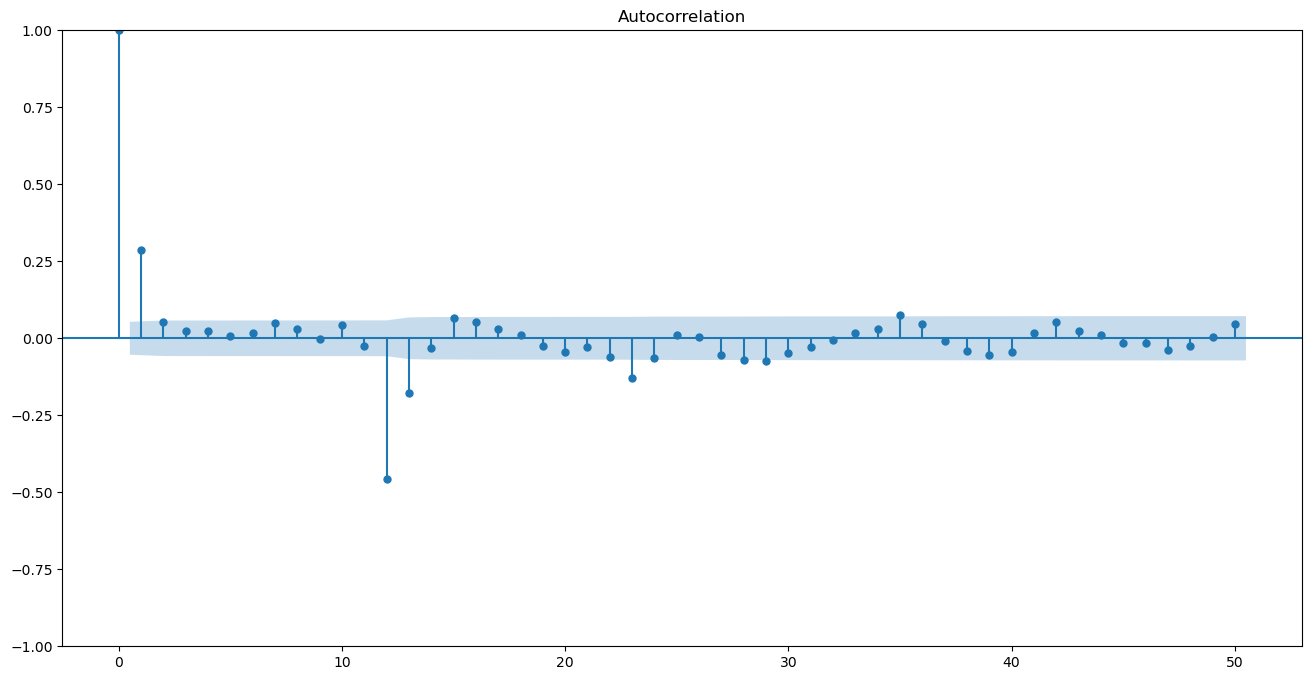

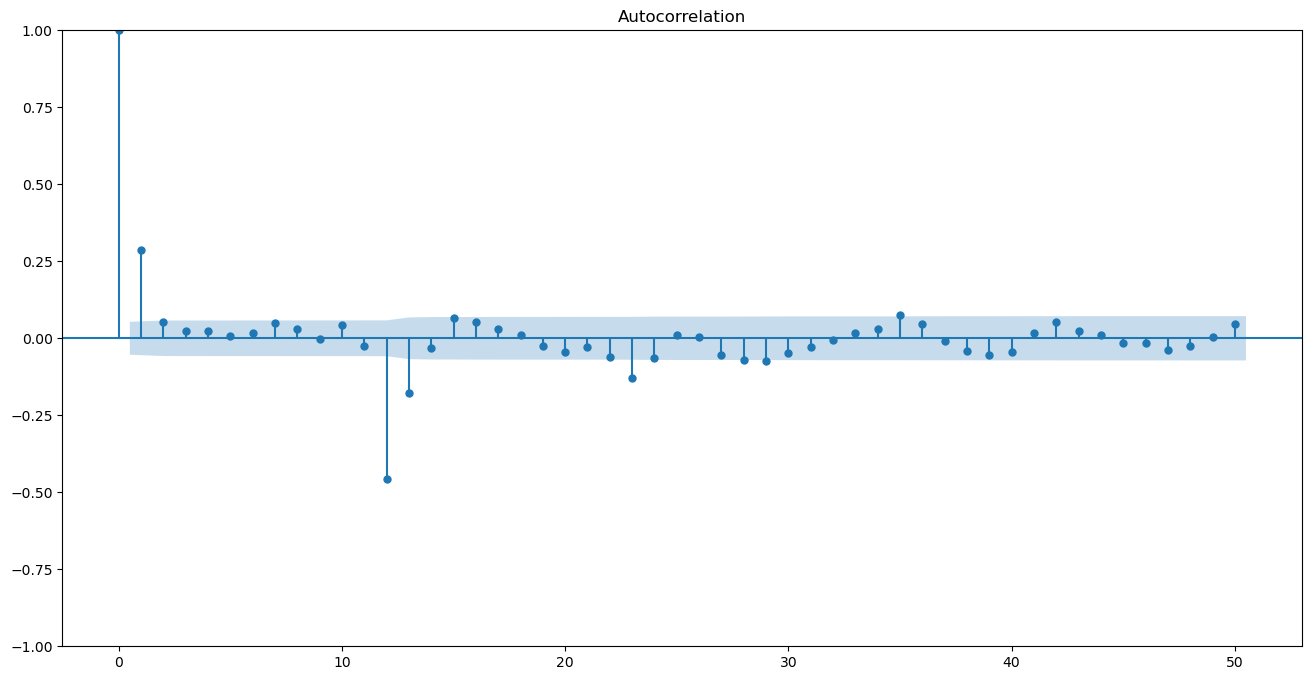

In [51]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_nonseasonal['lag1'],lags = 50)

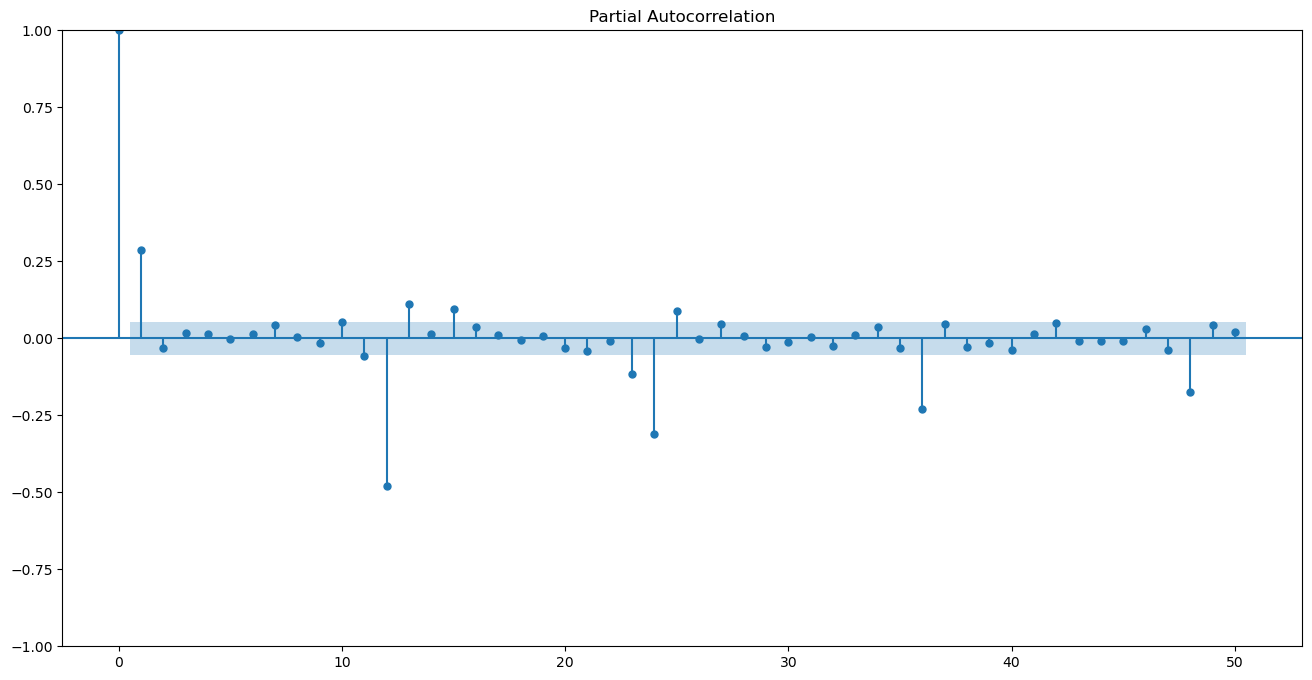

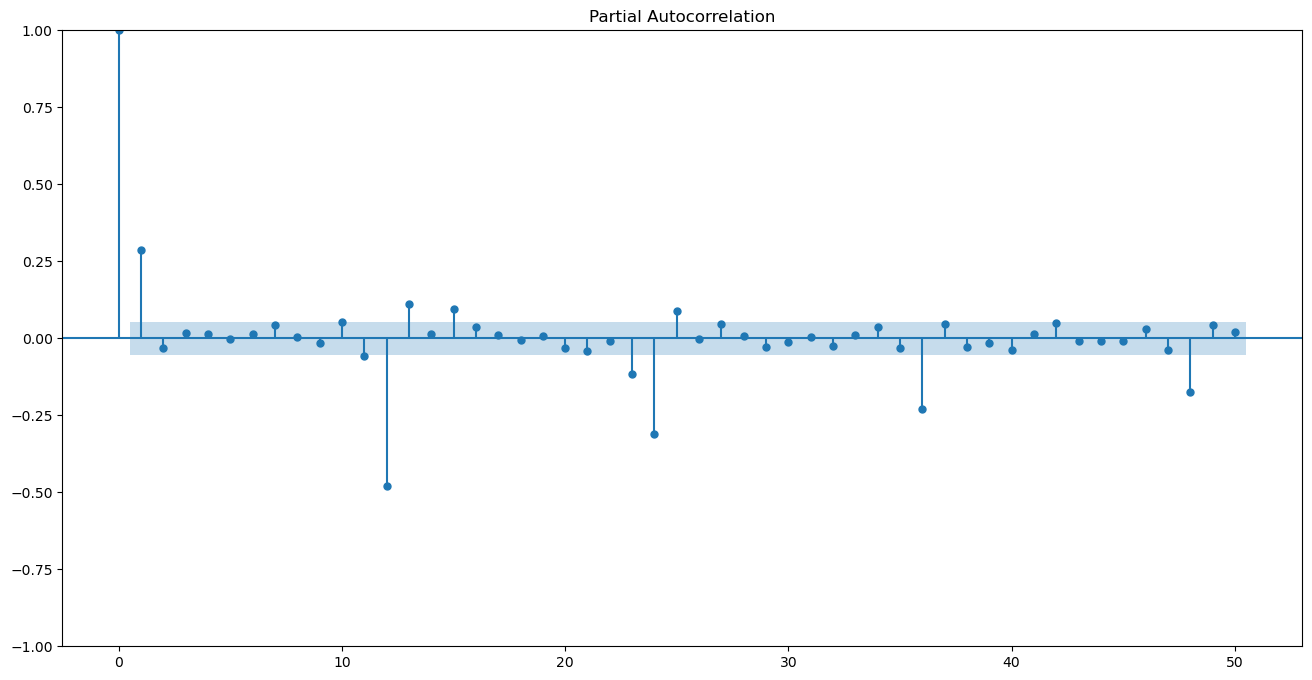

In [53]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_nonseasonal['lag1'],lags = 50)

## SARIMA model

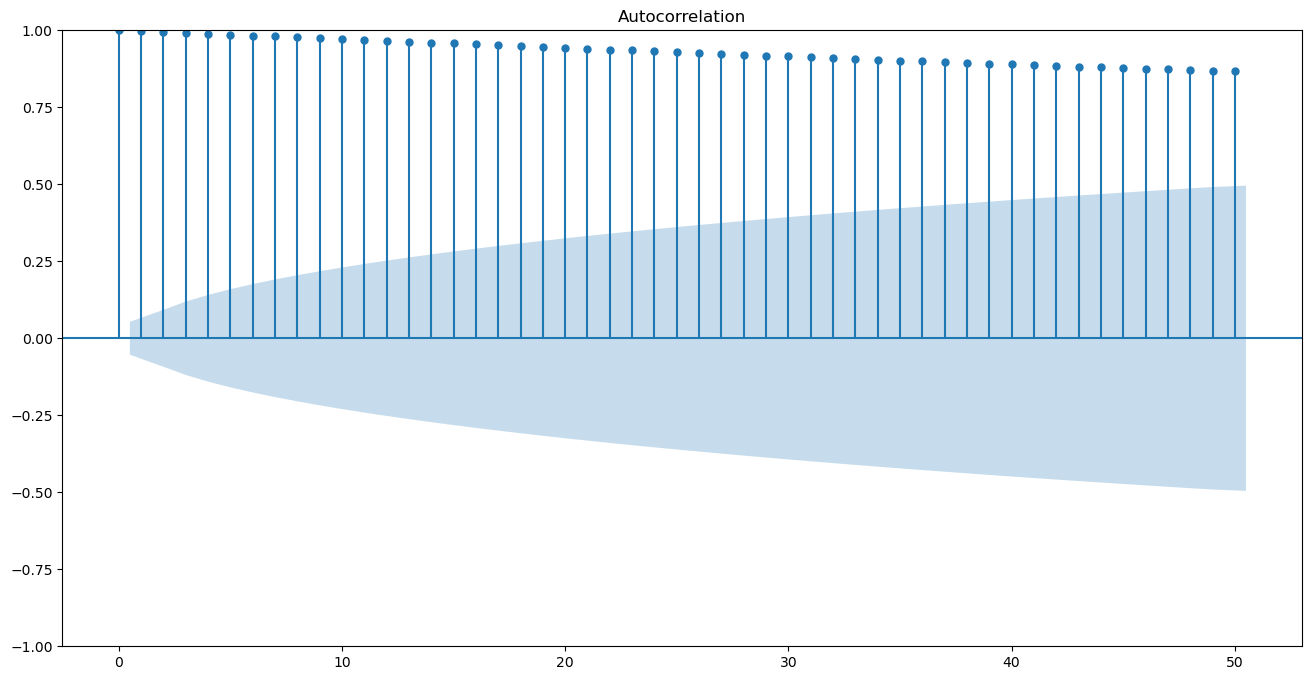

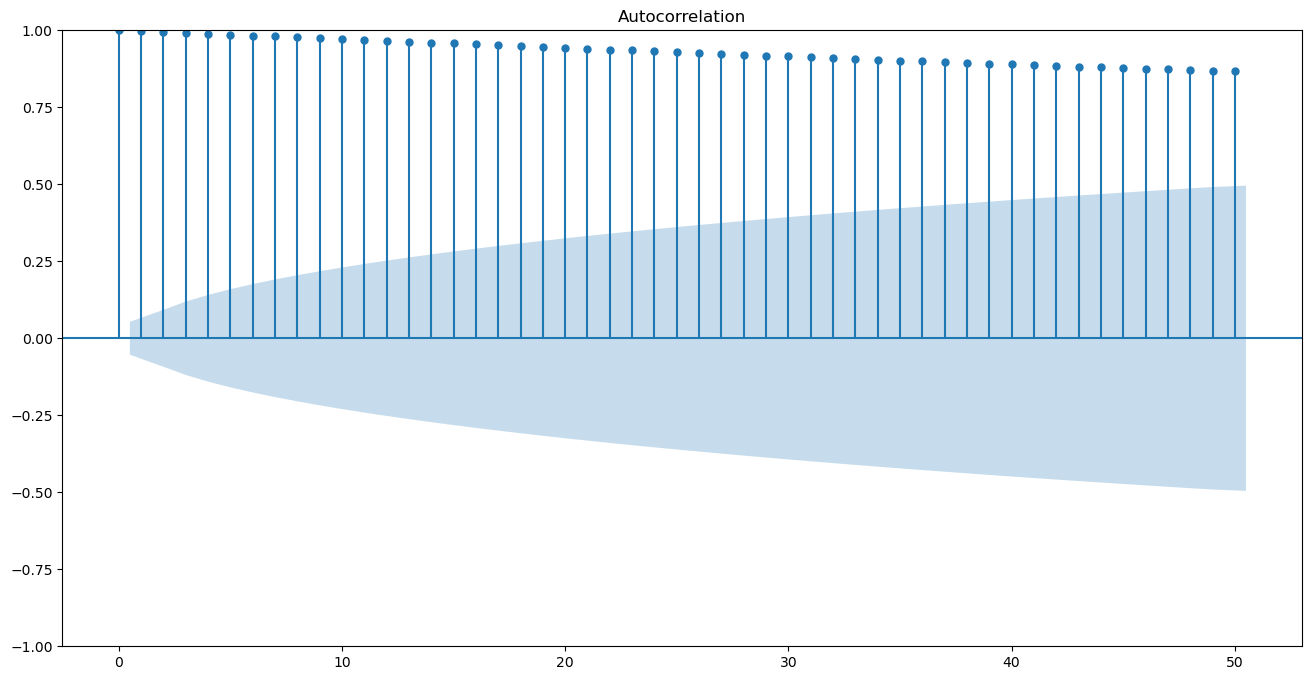

In [52]:

#autocorrelation plots for original data
plot_acf(df['CPI'],lags = 50)

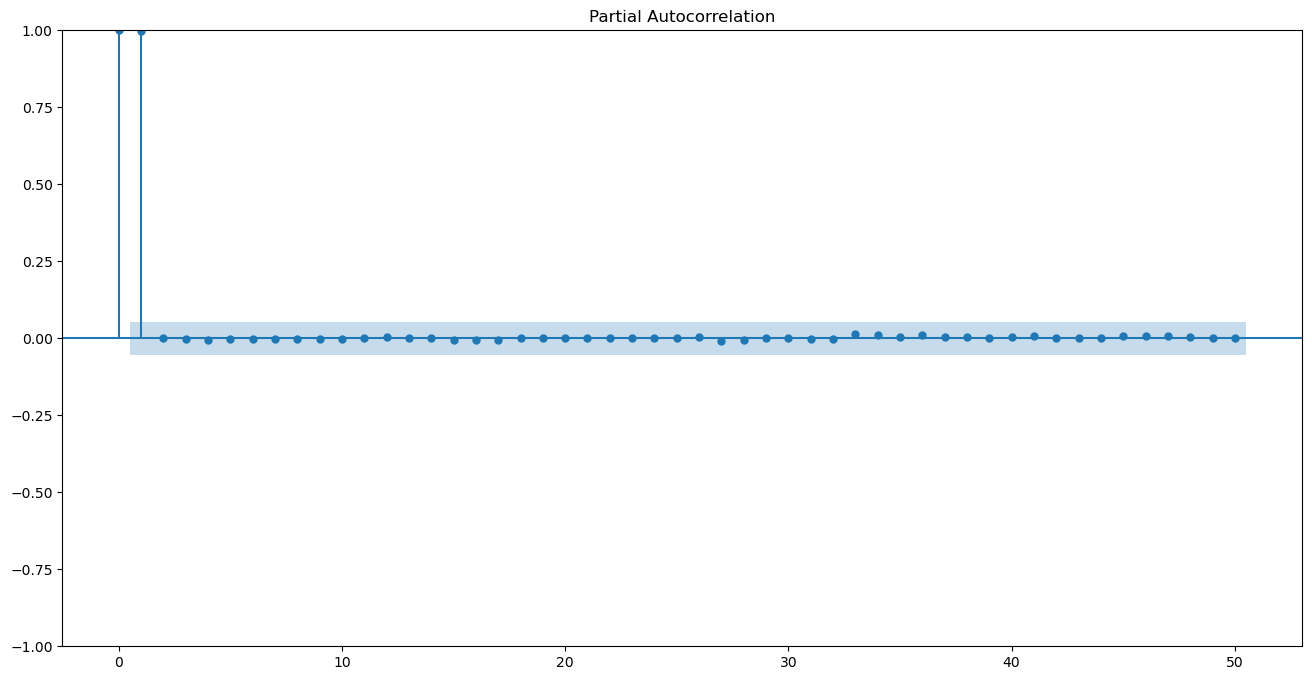

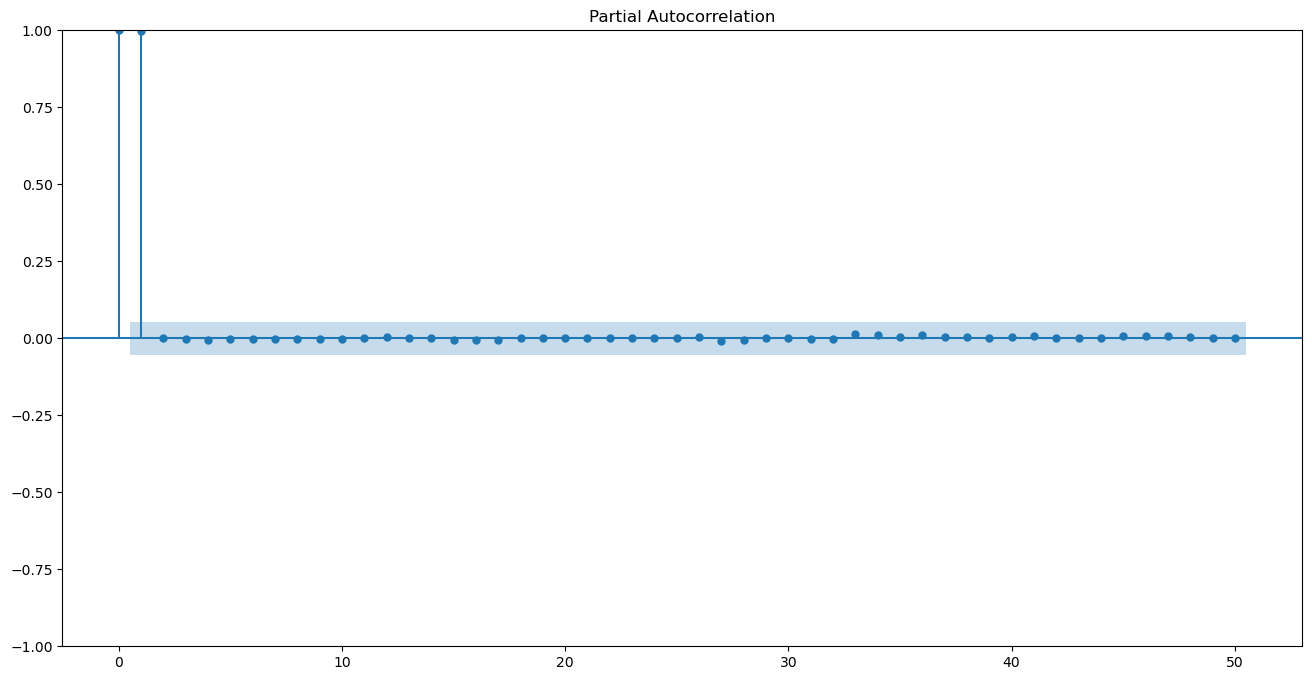

In [54]:
plot_pacf(df['CPI'],lags = 50)

## Train-Test Split

In [55]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_train = df.iloc[:int(0.9*df.shape[0]),:]
SARIMA_test = df.iloc[int(0.9*df.shape[0]):,:]
     

## Model

In [56]:
my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

SARIMA_model = SARIMAX(SARIMA_train, order=my_order, seasonal_order=my_seasonal_order)

SARIMA_model_fit = SARIMA_model.fit()
print(SARIMA_model_fit.summary())

c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                 1210
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -228.789
Date:                            Sun, 02 Mar 2025   AIC                            463.578
Time:                                    12:43:55   BIC                            478.841
Sample:                                01-01-1913   HQIC                           469.328
                                     - 10-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4471      0.010     43.285      0.000       0.427       0.467
ma.S.L12      -0.8546      0.009   

## Predictions
### Predictions for training data

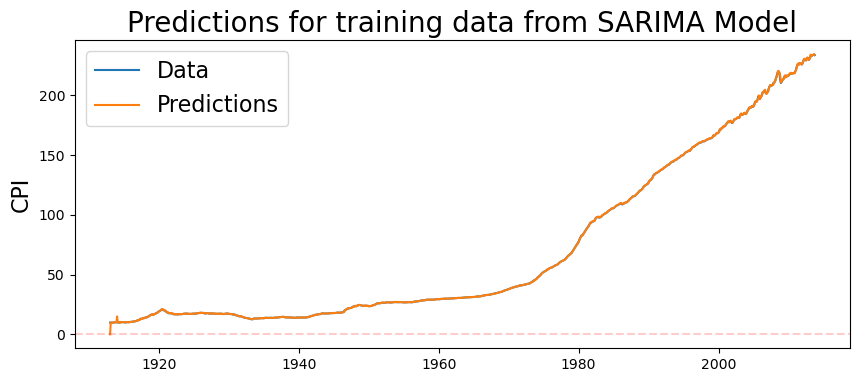

In [57]:

SARIMA_predictions = SARIMA_model_fit.predict(start = SARIMA_train.index[0], end = SARIMA_train.index[-1])
plt.figure(figsize=(10,4))
plt.plot(SARIMA_train)
plt.plot(SARIMA_predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Predictions for training data from SARIMA Model', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

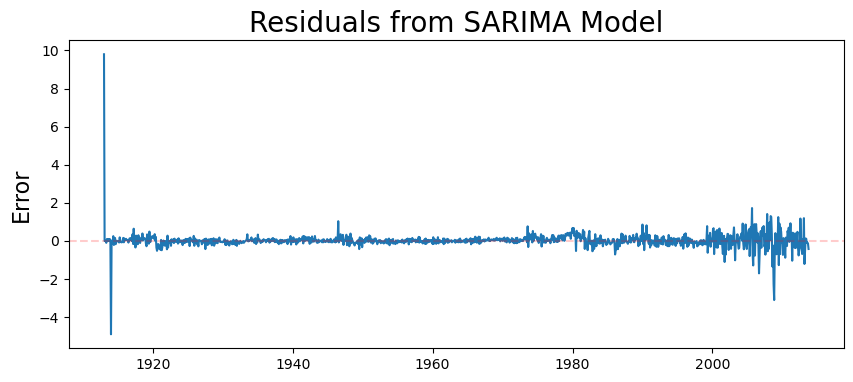

In [58]:

SARIMA_residuals = SARIMA_train['CPI'] - pd.DataFrame(SARIMA_predictions)['predicted_mean']
plt.figure(figsize=(10,4))
plt.plot(SARIMA_residuals)
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)